## Image Classification using Vision Transformers
> Vision transformers are better than normal CNN models

> Its a pre-trained vision transformer Algorithm

> It is used for Driving Analysis in car

> Dataset is pulled from kaggle



Importing Req lib

In [7]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import pandas as pd

Seeding for Randomness

In [2]:
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seeds()

Checking Cuda for GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


'cuda'

Pre-trained Vision Transformer Model

In [4]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 


In [5]:
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)


Frezzing the parameters

In [6]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [9]:
img_list = pd.read_csv('driver_images_list.csv')

In [11]:
img_list.drop(['Unnamed: 0'],axis=1,inplace=True)

In [66]:
class_names = img_list['labels'].unique()

In [67]:
class_names = class_names.tolist()

In [68]:
class_names

['safe driving',
 'texting - right',
 'talking on the phone - right',
 'texting - left',
 'talking on the phone - left',
 'operating the radio',
 'drinking',
 'reaching behind',
 'hair and makeup',
 'talking to passenger']

In [25]:
set_seeds()


Fine-tuning

In [26]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [27]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

trained Images.. dir

In [28]:
train_dir = 'drivers/train'

In [32]:
import os
os.listdir(train_dir)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

Pytorch Data_Loader for Image Data Loading, Transforming,Building in Batch

In [52]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def create_dataloaders(
    train_dir:str, 
    test_dir:str, 
    transform: transforms.Compose, 
    batch_size: int, 
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


Pre-trained model transform_fun

In [34]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()


In [37]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

root_dir = 'drivers/train'

train_dataset = ImageFolder(root=root_dir)

test_size = 0.2
num_samples = len(train_dataset)
num_test_samples = int(test_size * num_samples)
num_train_samples = num_samples - num_test_samples

train_dataset, test_dataset = random_split(train_dataset, [num_train_samples, num_test_samples])



In [50]:
import os
import random
from shutil import copyfile

root_dir = 'drivers/train'

train_dir = 'drivers/train_dataset'
test_dir = 'drivers/test_dataset'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        num_images = len(images)

        random.shuffle(images)

        num_train_images = int(num_images * 0.8)
        train_images = images[:num_train_images]
        test_images = images[num_train_images:]

        for img in train_images:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(train_dir, class_folder, img)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            copyfile(src_path, dst_path)

        for img in test_images:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(test_dir, class_folder, img)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            copyfile(src_path, dst_path)


In [51]:
train_dir = 'drivers/train_dataset'
test_dir = 'drivers/test_dataset'

In [55]:
train_dataloader_pretrained,test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=pretrained_vit_transforms,batch_size=32)

In [36]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

Training model Function

In [56]:
set_seeds()
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Compile model for 9 times

In [59]:
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=3,
                                      device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5228 | train_acc: 0.9127 | test_loss: 0.6209 | test_acc: 0.8664
Epoch: 2 | train_loss: 0.4687 | train_acc: 0.9286 | test_loss: 0.5671 | test_acc: 0.8605
Epoch: 3 | train_loss: 0.4228 | train_acc: 0.9345 | test_loss: 0.5337 | test_acc: 0.8859


In [60]:
from typing import List, Tuple

from PIL import Image


In [173]:
pretrained_vit_results

{'train_loss': [0.5228211373563797, 0.46868400488580975, 0.4228442476855384],
 'train_acc': [0.9126984126984127, 0.9285714285714286, 0.9345238095238095],
 'test_loss': [0.6209330447018147, 0.567109577357769, 0.5337029006332159],
 'test_acc': [0.86640625, 0.860546875, 0.8859375]}

In [69]:
class_names

['safe driving',
 'texting - right',
 'talking on the phone - right',
 'texting - left',
 'talking on the phone - left',
 'operating the radio',
 'drinking',
 'reaching behind',
 'hair and makeup',
 'talking to passenger']

Predicting model and Ploting it fun

In [70]:
def pred_and_plot(
        model:torch.nn.Module,
        class_names:List[str],
        image_path:str,
        image_size:Tuple[int,int]=(224,224),
        transform: torchvision.transforms=None,
        device:torch.device=device
):
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    
    #predict
    model.to(device)
    model.eval()

    with torch.inference_mode():
        transfomed_img = image_transform(img).unsqueeze(dim=0)
        target_image_pred= model(transfomed_img.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)
    

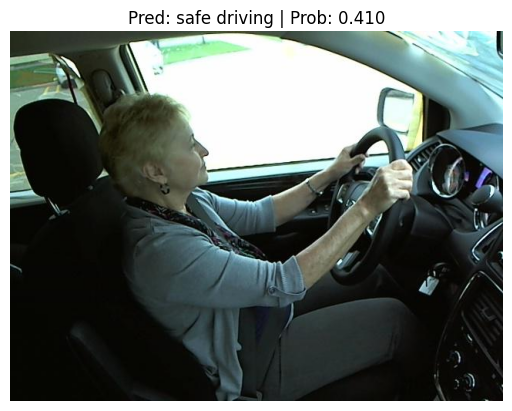

In [73]:
custom_image_path = "drivers/test_dataset/c0/img_97751.jpg"

# Predict on custom image
pred_and_plot(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

Saving Model and Loading

In [74]:
torch.save(pretrained_vit,'drivers_model.pth')

In [75]:
saved_model = torch.load('drivers_model.pth')

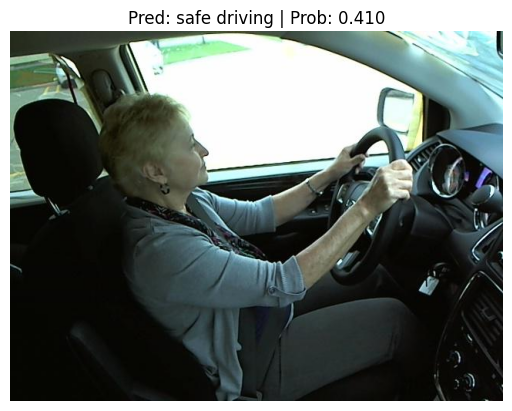

In [77]:
pred_and_plot(model=saved_model,
                    image_path=custom_image_path,
                    class_names=class_names)

Converting Images to Video

In [164]:
import cv2
import os
import random

def random_images_to_video(image_folder, video_name, duration_sec=40, fps=2, resolution=(1920, 1080)):
    all_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]

    # Calculate the number of frames needed to achieve the desired duration
    num_frames = int(duration_sec * fps)

    # Extend the list of images by repeating it as needed
    selected_images = random.sample(os.listdir('drivers/train_total'), 120)#random.sample(all_images, min(num_frames, len(all_images)))
    selected_images += selected_images[:num_frames - len(selected_images)]

    frame = cv2.imread(os.path.join(image_folder, selected_images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, resolution)

    for image in selected_images:
        frame = cv2.imread(os.path.join(image_folder, image))
        frame = cv2.resize(frame, resolution)
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()

# Replace 'path_to_images' with the path to your image folder
random_images_to_video('drivers/train_total', 'output_video.mp4', duration_sec=20, resolution=(1000,1000))


Web Interface for Algorithm 

In [170]:
import gradio as gr
import torch
from torchvision import transforms
from PIL import Image

# Load your pre-trained model
model = torch.load('drivers_model.pth')
class_names = ['safe driving',
 'texting - right',
 'talking on the phone - right',
 'texting - left',
 'talking on the phone - left',
 'operating the radio',
 'drinking',
 'reaching behind',
 'hair and makeup',
 'talking to passenger']  # Replace with your actual class names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def classify_image(image):
    # Create transformation for image
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Predict
    model.to(device)
    model.eval()

    with torch.inference_mode():
        transformed_img = image_transform(image).unsqueeze(dim=0)
        target_image_pred = model(transformed_img.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    return class_names[target_image_pred_label]

# Sample images for users to choose from
sample_images = [
    "drivers/train_total/img_232.jpg",
     "drivers/train_total/img_102119.jpg",
     "drivers/train_total/img_102025.jpg"
]

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload an image or choose a sample:"),
    outputs="text",
    live=True,
    examples=sample_images,
)

iface.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


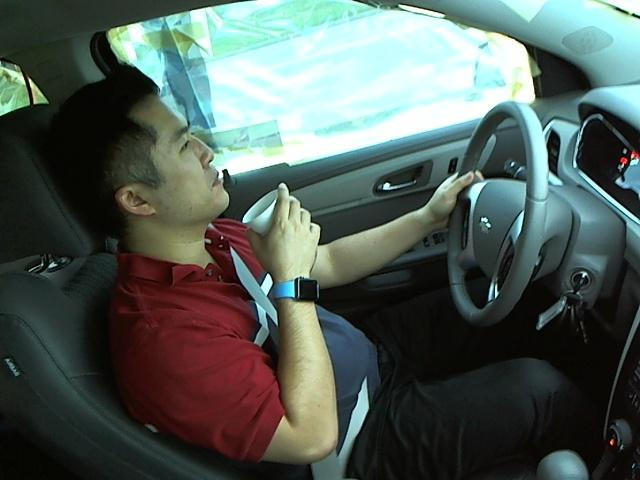

In [167]:
Image.open('drivers/train_total/img_232.jpg')

In [172]:
torch.save(pretrained_vit,'driver_model.pt')